# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [22]:
# carrega a base de treino e de testes
X_ = pd.read_csv('./UCI HAR Dataset/train/X_train.csv', index_col='subject_train')
X_test = pd.read_csv('./UCI HAR Dataset/test/X_test.csv', index_col='subject_test')

y_ = pd.read_csv('./UCI HAR Dataset/train/y_train.txt', delimiter=' ', header=None)
y_test = pd.read_csv('./UCI HAR Dataset/test/y_test.txt', delimiter=' ', header=None)

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.25, random_state=42)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [41]:
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)

# mostra as 'importances'
importances = clf.feature_importances_
list(importances)
# identifica as três principais
top_3 = np.argsort(importances)[::-1][:3]
print(f'Indices: {top_3}')

Indices: [ 52 393  41]


In [51]:
# selecionando as colunas referentes a lista 'top_3'
X_train_top_3 = X_train.iloc[:, top_3]
X_valid_top_3 = X_valid.iloc[:, top_3]
X_test_top_3 = X_test.iloc[:, top_3]

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [50]:
caminho = DecisionTreeClassifier(max_depth=4, random_state=42).cost_complexity_pruning_path(X_train_top_3, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

# seleciona apenas os valores maiores que zero e únicos
ccp_alphas = [ccp_alpha for ccp_alpha in set(ccp_alphas) if ccp_alpha > 0]

# testa as arvores para cada valor de ccp_alpha obtido
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=4, random_state=42, ccp_alpha=ccp_alpha).fit(X_train_top_3, y_train)
    clfs.append(clf)

# avalia a arvore na base de treino e validação
train_scores = [clf.score(X_train_top_3, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid_top_3, y_valid) for clf in clfs]

# mostra a melhor arvore
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')


Acurácia da melhor árvore na base de validação: 81.39


### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

In [67]:
test_scores = [melhor_arvore.score(X_test_top_3, y_test)]
print(f'Score na base testes: {round(test_scores[0], 2)}')


Score na base testes: 0.71


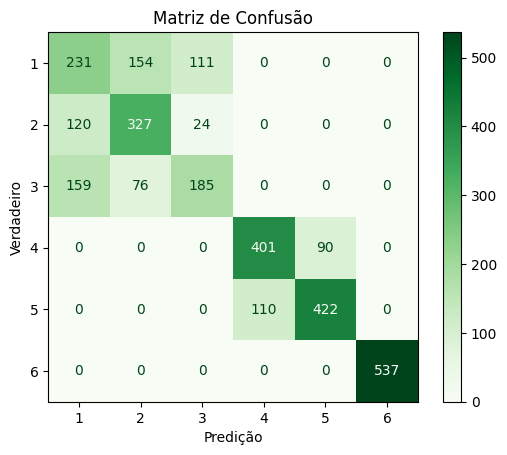

In [74]:
# matriz de confusão (sendo 1 a 6 as atividades descritas na base de dados)
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test_top_3,
    y_test,
    cmap=plt.cm.Greens,
)

disp.ax_.set_title('Matriz de Confusão')
disp.ax_.set_xlabel('Predição')
disp.ax_.set_ylabel('Verdadeiro')    

plt.show() 
